In [71]:
# simple_langgraph_llama.py

from langchain_community.chat_models import ChatOllama
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
import operator


In [72]:
class Batsman_State(TypedDict):
    runs : int
    balls : int
    no_fours : int
    no_sixes : int

    strike_rate: float
    balls_per_boundary: float
    boundary_percentage: float

In [73]:
def calculate_strike_rate(state: Batsman_State):
    state["strike_rate"] = (state["runs"] / state["balls"]) * 100 if state["balls"] > 0 else 0
    return {"strike_rate": state["strike_rate"]}

In [74]:
def calculate_balls_per_boundary(state: Batsman_State) :
    state["balls_per_boundary"] = state["balls"] / (state["no_fours"] + state["no_sixes"]) if (state["no_fours"] + state["no_sixes"]) > 0 else 0
    return {"balls_per_boundary": state["balls_per_boundary"]}

In [75]:
def calculate_boundary_percentage(state: Batsman_State) :
    total_balls = state["balls"]
    if total_balls > 0:
        state["boundary_percentage"] = ((state["no_fours"] * 4 + state["no_sixes"] * 6) / (total_balls * 6)) * 100
    else:
        state["boundary_percentage"] = 0
    return {"boundary_percentage": state["boundary_percentage"]}

In [76]:
def calculate_summary(state: Batsman_State) -> str:
    summary = f"""
Batsman Summary:
Runs: {state["runs"]}
Balls: {state["balls"]}
Fours: {state["no_fours"]}
Sixes: {state["no_sixes"]}
Strike Rate: {state["strike_rate"]:.2f}
Balls per Boundary: {state["balls_per_boundary"]:.2f}
Boundary Percentage: {state["boundary_percentage"]:.2f}%
"""
    return {"summary": summary}

In [77]:
graph = StateGraph(Batsman_State)

graph.add_node("calculate_strike_rate",calculate_strike_rate)
graph.add_node("calculate_balls_per_boundary",calculate_balls_per_boundary)
graph.add_node("calculate_boundary_percentage",calculate_boundary_percentage)
graph.add_node("calculate_summary",calculate_summary)

# edges
# parallel execution
graph.add_edge(START, "calculate_strike_rate")
graph.add_edge(START, "calculate_balls_per_boundary")
graph.add_edge(START, "calculate_boundary_percentage")

# Joining the results
graph.add_edge('calculate_strike_rate', 'calculate_summary')
graph.add_edge('calculate_balls_per_boundary', 'calculate_summary')
graph.add_edge('calculate_boundary_percentage', 'calculate_summary')
graph.add_edge('calculate_summary', END)

workflow = graph.compile()



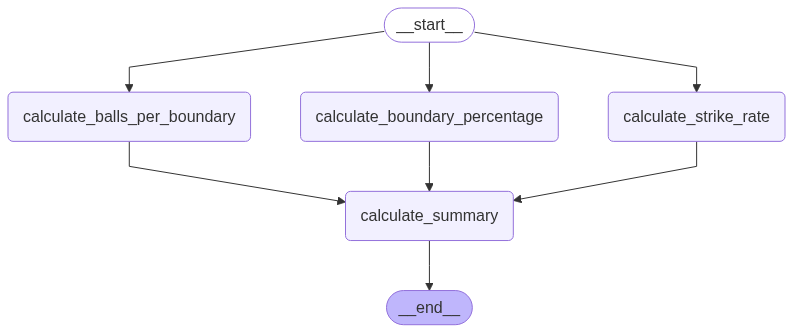

In [78]:
workflow

In [82]:
initial_state = {
    "runs": 50,
    "balls": 50,
    "no_fours": 5,
    "no_sixes": 2,
}

workflow_state = workflow.invoke(initial_state)
workflow_state

{'runs': 50,
 'balls': 50,
 'no_fours': 5,
 'no_sixes': 2,
 'strike_rate': 100.0,
 'balls_per_boundary': 7.142857142857143,
 'boundary_percentage': 10.666666666666668}

In [80]:
# Create Ollama LLaMA model
llm = ChatOllama(
    model="llama3.2:1b",  # <-- or "llama3", or any valid name from `ollama list`
    base_url="http://localhost:11434"
)